# SBI Tutorial
(adapted from https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started.ipynb)

In [1]:
#%pip install torch sbi

In [3]:
import torch
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
%matplotlib widget

ModuleNotFoundError: No module named 'sbi'

In [ ]:
seed = 0
torch.manual_seed(seed);

## Parameter inference in a linear example with Gaussian noise

For the inference, we need to define **3 components**:
1. observational data (or summary statistics thereof): the observations
2. a model: the simulator
3. prior knowledge or constraints on model parameters: the prior

### Simulator
For this illustrative example we consider a model simulator that takes in 3 parameters (θ). 
For simplicity, the simulator outputs simulations of the same dimensionality and adds 1.0 and some Gaussian noise to the parameter set. 

In [3]:
def simulator(θ):
    # linear + Gaussian noise
    d = θ + 1.0 + torch.randn_like(θ) * 0.1  # observation d
    return d

### Prior
For the 3-dimensional parameter space we consider a uniform prior between [-2,2] for each parameter.

In [4]:
num_dim = 3
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [5]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [6]:
print(prior)
print(num_parameters)
print(prior_returns_numpy)

BoxUniform(Uniform(low: torch.Size([3]), high: torch.Size([3])), 1)
3
False


### Simulating data
Next, we need simulations, or more specifically, pairs of parameters θ which we sample from the prior and corresponding simulations $d =$ simulator$(θ)$. 

In [7]:
num_simulations = 2000
θ = prior.sample((num_simulations,))
d = simulator(θ)
print("theta.shape", θ.shape)
print("d.shape", d.shape)

theta.shape torch.Size([2000, 3])
d.shape torch.Size([2000, 3])


Pairplot of the **parameters $θ$**

(<Figure size 1000x1000 with 9 Axes>,
 array([[<AxesSubplot:xlabel='$θ_1$'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='$θ_2$'>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='$θ_1$'>, <AxesSubplot:xlabel='$θ_2$'>,
         <AxesSubplot:xlabel='$θ_3$'>]], dtype=object))

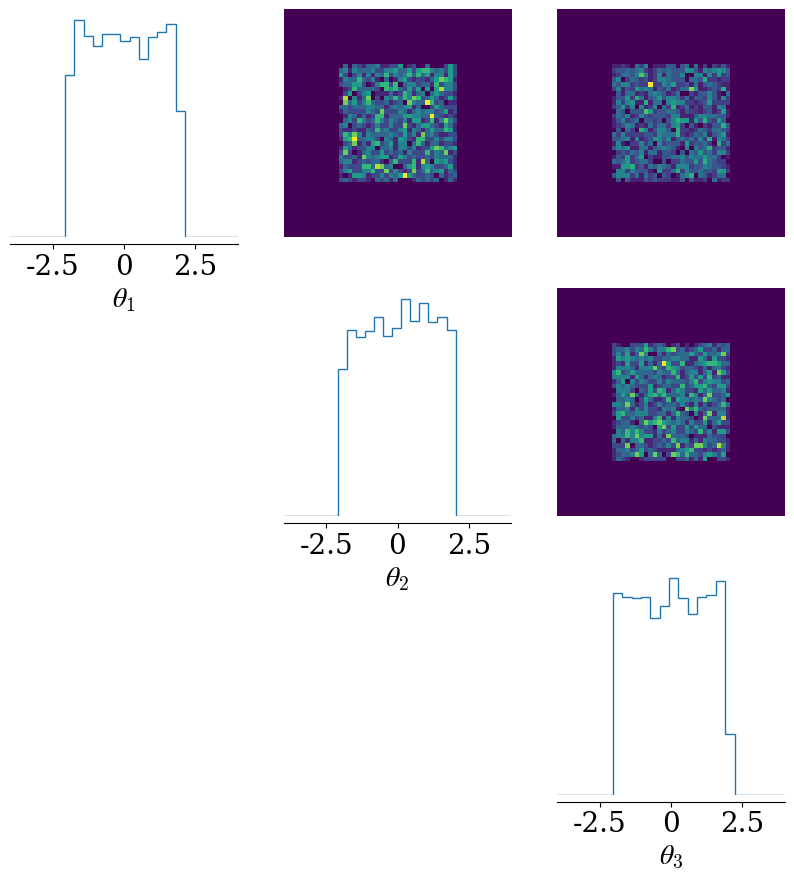

In [8]:
pairplot(θ, limits=[[-4, 4], [-4, 4], [-4, 4]], labels=[r"$θ_1$", r"$θ_2$", r"$θ_3$"])

Pairplot of the **simulations $d$**

(<Figure size 1000x1000 with 9 Axes>,
 array([[<AxesSubplot:xlabel='$d_1$'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='$d_2$'>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='$d_1$'>, <AxesSubplot:xlabel='$d_2$'>,
         <AxesSubplot:xlabel='$d_3$'>]], dtype=object))

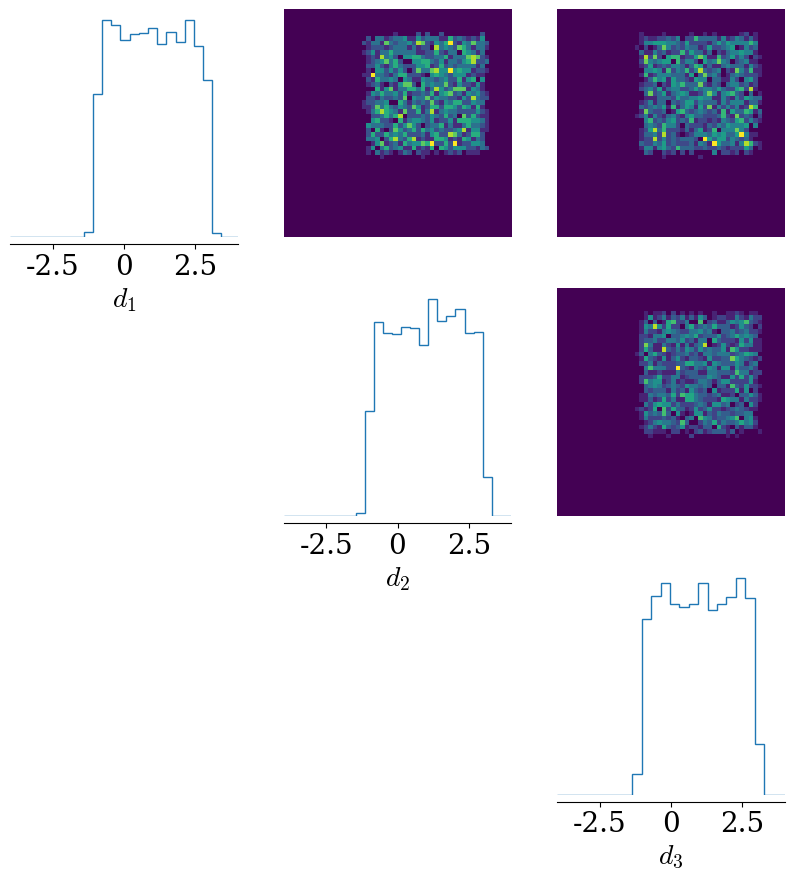

In [9]:
pairplot(d, limits=[[-4, 4], [-4, 4], [-4, 4]], labels=[r"$d_1$", r"$d_2$", r"$d_3$"])

### Choosing an SBI flavour
Here, we choose the Neural Posterior Estimation (NPE) algorithm for parameter inference.

In [10]:
inference = NPE(prior=prior)  # default normalizing flow: masked autoregressive flow, see https://arxiv.org/abs/1705.07057

Pass the simulations to the model

In [11]:
inference = inference.append_simulations(θ, d)

Train the network

In [12]:
density_estimator = inference.train()

 Neural network successfully converged after 143 epochs.

### Evaluation
Finally, we use this density estimator to build the posterior distribution $p(θ | d)$, i.e., the distributions over parameters $θ$ given observation $d$.
The posterior can then be used to sample parameters $θ$ from the posterior via `.sample()`, i.e., parameters that are likely given the observation $d$.
We can also get log-probabilities under the posterior via `.log_prob()`, i.e., we can evaluate the probability of parameters $θ$ given the observation $d$. 

In [13]:
posterior = inference.build_posterior(density_estimator)
print(posterior) # prints how the posterior was trained

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


### Visualisations of the inferred posterior for a new observation
Let’s say we have made some observation $d_{\mathrm{obs}}$ for which we now want to infer the posterior:


In [14]:
θ_true = prior.sample((1,))  # True parameters
d_obs = simulator(θ_true)  # Corresponding observation

In [15]:
print("True parameters", θ_true)
print("Observed data", d_obs)

True parameters tensor([[ 1.2112,  0.4730, -1.4803]])
Observed data tensor([[ 2.1064,  1.5585, -0.4796]])


Given this observation, we can sample from the posterior $p(θ | d_{\mathrm{obs}})$ and visualise the posterior. Visualizing a three-dimensional distributions is challenging. Therefore, we use `sbi`’s pairplot function that generates a upper triangular grid of plots, showing the univariate marginals on the diagonal and every combination of pairwise marginals for the three parameters on the upper off-diagonal:

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

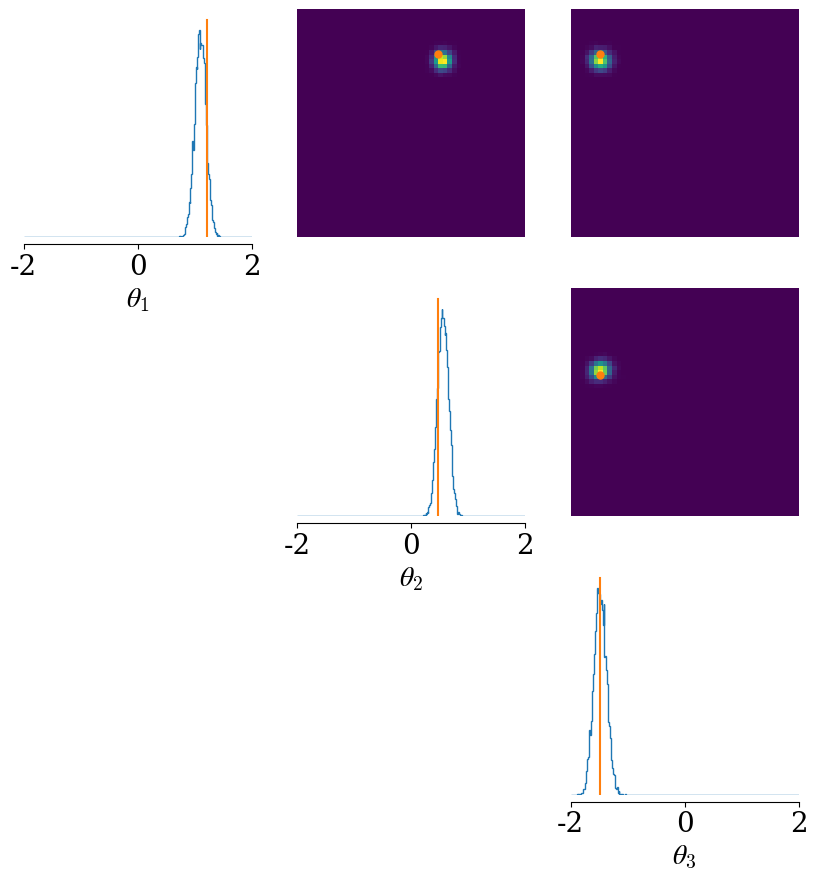

In [16]:
samples = posterior.sample((10000,), x=d_obs)
_ = pairplot(samples,
             points=θ_true,
             limits=[[-2, 2], [-2, 2], [-2, 2]],             
             labels=[r"$θ_1$", r"$θ_2$", r"$θ_3$"])


### Assessing the predictive performance of the posterior
Another way to assess the quality of the posterior is checking whether parameters sampled from the posterior $p(θ ∣ d_\mathrm{obs})$ can reproduce the observation $d_{\mathrm{obs}}$ when we simulate data with them. This posterior predictive distribution, which is given by
$$
p(d | d_{\mathrm{obs}}) = \int p(d | θ) p(θ | d_{\mathrm{obs}}) \, \mathrm{d}θ,
$$
should contain $d_{\mathrm{obs}}$. We can again use the pairplot function to visualize it.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

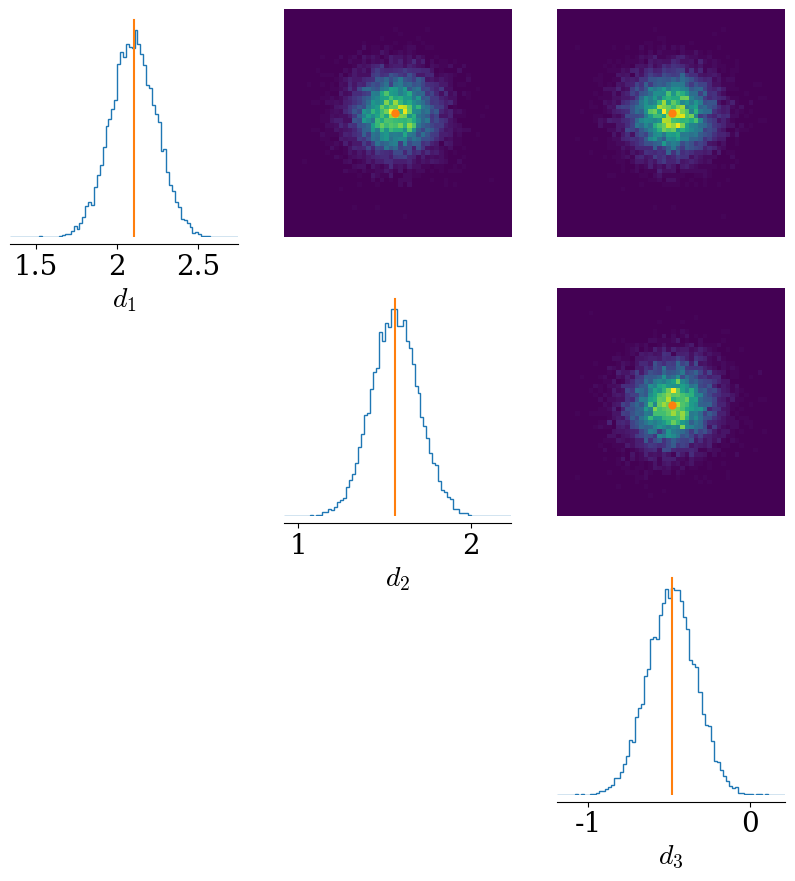

In [17]:
θ_posterior = posterior.sample((10000,), x=d_obs)  # sample from posterior
d_predictive = simulator(θ_posterior)  # simulate data from posterior
pairplot(d_predictive,
         points=d_obs,  # plot with d_obs as a point         
         labels=[r"$d_1$", r"$d_2$", r"$d_3$"]);